In [ ]:
# 📌 Step 1: Install Required Libraries
#!pip install -q transformers farasapy scikit-learn pandas tqdm

In [43]:
# 📌 Step 2: Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch
from farasa.segmenter import FarasaSegmenter
import matplotlib.pyplot as plt

In [45]:
# 📌 Step 3: Load Dataset
df = pd.read_csv('full_data_fusionne.csv')
df = df.dropna(subset=['title'])  # Remove rows with missing titles
titles = df['title'].astype(str).tolist()

In [46]:
# 📌 Step 4: Arabic Preprocessing
segmenter = FarasaSegmenter(interactive=True)

def preprocess_arabic(text):
    return segmenter.segment(text)

titles_preprocessed = [preprocess_arabic(t) for t in tqdm(titles)]

[2025-04-06 21:01:04,960 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
100%|██████████████████████████████████████████████████████████████████████████| 41554/41554 [00:27<00:00, 1512.54it/s]


In [47]:
# 📌 Step 5: Load BERT Model & Tokenizer
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(64000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [48]:
# 📌 Step 6: Generate Embeddings
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

embeddings = np.array([get_cls_embedding(t) for t in tqdm(titles_preprocessed)])

100%|██████████████████████████████████████████████████████████████████████████| 41554/41554 [1:20:45<00:00,  8.58it/s]


In [49]:
# 📌 Step 7: KMeans Clustering
n_clusters = 5  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

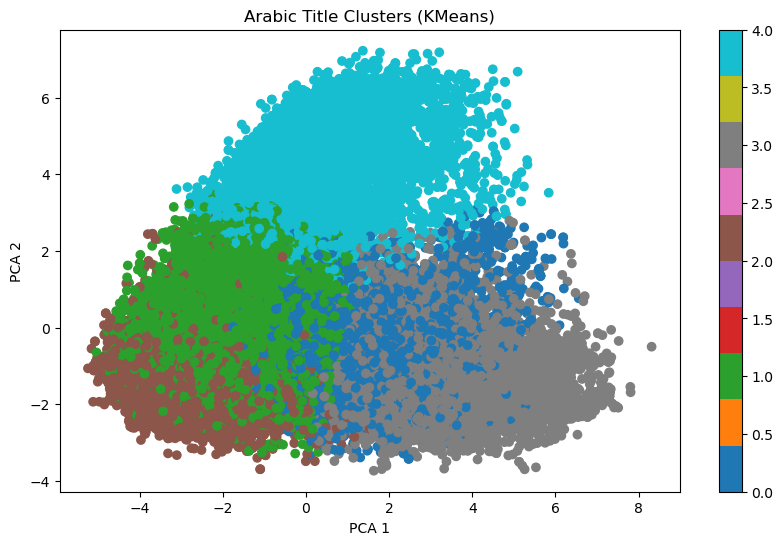

In [50]:
# 📌 Step 8: (Optional) Visualization with PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='tab10')
plt.title("Arabic Title Clusters (KMeans)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter)
plt.show()

In [51]:
# 📌 Step 9: View Example Titles in Each Cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))


Cluster 0:
وصول نعش إسماعيل هنية إلى الدوحة بعد جنازة حاشد...
حزب الله يؤكد مقتل فؤاد شكر بضربة إسرائيلية وخط...
                تونس.. شباب يبتكرون روبوتا تفاعليا
أربعة محاور لمعرفة تفاصيل الهجوم البري الإسرائي...
مفرقعات وتوزيع حلوى في إدلب السورية ابتهاجا بمق...

Cluster 1:
تنديدا باغتيال هنية... مظاهرات مناهضة لإسرائيل ...
خليل الحية عن اغتيال هنية.. هذه جريمة لا بد لمر...
اغتيال إسماعيل هنية.. واشنطن تنفي تورطها وقلق د...
الجيش الإسرائيلي يؤكد "مقتل" قائد الجناح العسكر...
إسرائيل تؤكد "مقتل" محمد الضيف بضربة جوية على غ...

Cluster 2:
الألعاب الأولمبية: الملاكمة خليف تبلغ ربع النها...
إسرائيل "تغتال" صحفيا ومصورا من قناة الجزيرة في...
إجراءات أمنية مشددة في إسرائيل تحسبا لسيناريوها...
تبادل عدة سجناء بين روسيا وعدة دول غربية بينهم ...
صفقة تبادل كبيرة لسجناء بين روسيا وعدة دول بتنس...

Cluster 3:
  نصرالله: على إسرائيل أن تنتظر "ردّنا الآتي حتما"
    قصف مدفعي كثيف وغارات إسرائيلية على جنوب لبنان
اتفاق أمريكي-إسرائيلي على "تفكيك البنى التحتية"...
الجيش اللبناني وحزب الله ينفيان حص

In [52]:
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings, df['cluster'])
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.0564


In [53]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, preds)
    print(f"k={k} --> Silhouette Score: {score:.4f}")


k=2 --> Silhouette Score: 0.0813
k=3 --> Silhouette Score: 0.0817
k=4 --> Silhouette Score: 0.0680
k=5 --> Silhouette Score: 0.0564
k=6 --> Silhouette Score: 0.0510
k=7 --> Silhouette Score: 0.0548
k=8 --> Silhouette Score: 0.0599
k=9 --> Silhouette Score: 0.0580
k=10 --> Silhouette Score: 0.0491


In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_pca)

sil_score = silhouette_score(embeddings_pca, df['cluster'])
print(f"Silhouette Score after PCA: {sil_score:.4f}")


Silhouette Score after PCA: 0.0829


In [73]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
df['cluster_hdbscan'] = clusterer.fit_predict(embeddings_pca)

# Check number of clusters found
print(f"HDBSCAN found {df['cluster_hdbscan'].nunique()} clusters")

# Silhouette Score (only for non-outliers)
mask = df['cluster_hdbscan'] != -1
print("Silhouette Score (HDBSCAN):", silhouette_score(embeddings_pca[mask], df['cluster_hdbscan'][mask]))


HDBSCAN found 2 clusters
Silhouette Score (HDBSCAN): 0.5673016


In [56]:
for i in sorted(df['cluster_hdbscan'].unique()):
    if i == -1:
        print(f"\nCluster -1 (outliers):")
    else:
        print(f"\nCluster {i}:")
    print(df[df['cluster_hdbscan'] == i]['title'].head(5).to_string(index=False))



Cluster 0:
إسرائيل تواصل قصف غزة غداة مقترح جديد لوقف إطلا...
              فرنسا: هل دقت ساعة النهاية لبارنييه؟
                        غزة: هل تبددت آمال الهدنة؟
    غارات إسرائيلية مكثفة ومستشفيات غزة تعج بالجثث
             مشاركة قياسية وسط إجراءات أمنية مشددة

Cluster 1:
الألعاب الأولمبية: الملاكمة خليف تبلغ ربع النها...
محطة أفريقيا في الألعاب الأولمبية بباريس: "خيمة...
تنديدا باغتيال هنية... مظاهرات مناهضة لإسرائيل ...
إسرائيل "تغتال" صحفيا ومصورا من قناة الجزيرة في...
خليل الحية عن اغتيال هنية.. هذه جريمة لا بد لمر...


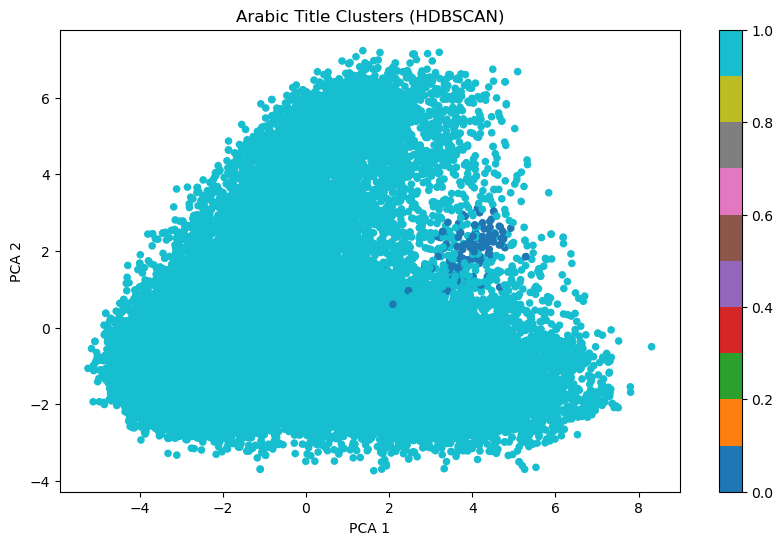

In [57]:
plt.figure(figsize=(10, 6))
colors = df['cluster_hdbscan']
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colors, cmap='tab10', s=20)
plt.title("Arabic Title Clusters (HDBSCAN)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter)
plt.show()
